4 Physical GPUs, 1 Logical GPU


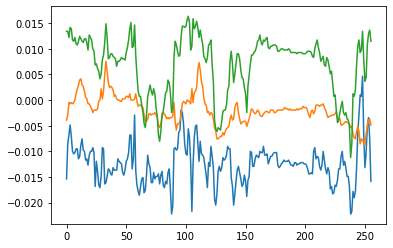

Epoch 1/100
63/63 [==============================] - 4s 42ms/step - loss: 2.5987 - val_loss: 2.7292
Epoch 2/100
63/63 [==============================] - 2s 27ms/step - loss: 2.3842 - val_loss: 2.7486
Epoch 3/100
63/63 [==============================] - 2s 26ms/step - loss: 2.2488 - val_loss: 2.7518
Epoch 4/100
63/63 [==============================] - 2s 26ms/step - loss: 2.1575 - val_loss: 2.7339
Epoch 5/100
63/63 [==============================] - 2s 27ms/step - loss: 2.0560 - val_loss: 2.5767
Epoch 6/100
63/63 [==============================] - 2s 27ms/step - loss: 1.9615 - val_loss: 2.3990
Epoch 7/100
63/63 [==============================] - 2s 27ms/step - loss: 1.8306 - val_loss: 1.9535
Epoch 8/100
63/63 [==============================] - 2s 27ms/step - loss: 1.7788 - val_loss: 2.3189
Epoch 9/100
63/63 [==============================] - 2s 27ms/step - loss: 1.6905 - val_loss: 2.0252
Epoch 10/100
63/63 [==============================] - 2s 27ms/step - loss: 1.6086 - val_loss: 1.8974

In [2]:
import pickle
import numpy as np
np.random.seed(100)
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler,RobustScaler
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D,BatchNormalization,Dropout,Input,MaxPooling1D,Flatten,Dense,Input,Reshape
from tensorflow.keras.models import Model, Sequential
from keras.models import load_model
import pickle

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)


def get_model(input_shape=(256,3),act='relu',loss="categorical_crossentropy",opt='adam',
              n_classes=300,n_output = 15):
    
    
    model =  Sequential()
    model.add(Input(shape=input_shape))
    model.add(Reshape(input_shape))
    model.add(Conv1D(100,40,input_shape=input_shape,activation='selu',kernel_initializer='normal',padding='same'))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(Conv1D(50,40,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    
    model.add(Conv1D(100,20,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(MaxPooling1D(2))
    model.add(BatchNormalization())
    model.add(Dropout(.2))
    model.add(Conv1D(200,2,activation='relu',kernel_initializer='normal',padding='same'))
    model.add(BatchNormalization())
#     model.add(Bidirectional(GRU(10,activation='relu',return_sequences=True)))
    model.add(Dropout(.2))
    model.add(Flatten())
#     model.add(Dense(n_classes,activation='relu'))
#     model.add(Dense(n_output*2,activation='relu'))
    model.add(Dense(n_output,activation=None))
#     model.summary()
    input_ = Input(shape=input_shape)
    reshaped_input = Reshape(input_shape)(input_)
    embedding = model(reshaped_input)
    embedding = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1),name='feature')(embedding)
    
#     embedding = Dense(n_output,activation='relu')(embedding)
    y_output = Dense(n_output,activation='softmax',name='output')(embedding) 
    model1 = Model(input_,y_output)
#     model1.compile(loss={'output':tf.keras.losses.SparseCategoricalCrossentropy(),
#                         'feature':tfa.losses.TripletSemiHardLoss()},optimizer=opt,
#                    loss_weights={'output':1,'feature':0})
    model1.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),optimizer='adam')
    return model1


def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

def get_train_test_val_data(X_hr,y_participant,y_activity,y_time):
    all_data = pd.DataFrame({'x':np.arange(X_hr.shape[0]),'y':y_participant,'activity':y_activity,'time':y_time})
    train_percentage = .5
    val_percentage = train_percentage+.1
    def split_data(df):
        df = df.sort_values('time').reset_index(drop=True)
        n = df.shape[0]
        train_index = df['x'].values[:int(n*train_percentage)]
        val_index = df['x'].values[int(n*train_percentage):int(n*val_percentage)]
        test_index = df['x'].values[int(n*val_percentage):]
        return pd.DataFrame({'train':[list(train_index)],'val':[list(val_index)],'test':[list(test_index)]})

    index_df = all_data.groupby(['y','activity'],as_index=False).apply(split_data)

    from functools import reduce
    train_index = np.array(reduce(lambda a,b:a+b,index_df['train'].values))
    val_index = np.array(reduce(lambda a,b:a+b,index_df['val'].values))
    test_index = np.array(reduce(lambda a,b:a+b,index_df['test'].values))


    train_x,train_y = X_hr[train_index],y_participant[train_index]
    val_x,val_y = X_hr[val_index],y_participant[val_index]
    test_x,test_y = X_hr[test_index],y_participant[test_index]
    return train_x,train_y,val_x,val_y,test_x,test_y,train_index,test_index,val_index 

def train_model(k,model,train_x,train_y,val_x,val_y):
    filepath = '../model_files/person_estimator_8_secs_dalia_'+str(k+1)+'samples.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min',save_weights_only=False)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=20)
    callbacks_list = [es,checkpoint]
    history = model.fit(train_x,train_y,validation_data=(val_x,val_y), epochs=100, batch_size=200,verbose=1,
          callbacks=callbacks_list,shuffle=True)
    model.load_weights(filepath)
    return model

def get_performance(val_x,val_y,model):
    print(classification_report(val_y,model.predict(val_x).argmax(axis=1)))
    return accuracy_score(val_y,model.predict(val_x).argmax(axis=1))
window_size = 8
n_timesteps = window_size*32
n_channels = 3

results = []
# for k in range(0,32*7,32):
for k in [256]:
    X,y_hr,y_participant,y_activity,y_time = pickle.load(open('../data/heart_rate_tabular_data_ppg_dalia.p','rb'))
    X = X[:,:,1:].reshape(-1,256,3)
#     if k==1:
#         plt.plot(X[0])
#         plt.show()
#     arrays = np.array_split(X,k,axis=1)
# #     print(len(arrays))
#     X = []
#     for a in arrays:
#         X.append(np.concatenate([np.mean(a,axis=1).reshape(a.shape[0],-1,a.shape[2])]*a.shape[1],axis=1))
#     X = np.concatenate(X,axis=1)
    plt.plot(X[0])
    plt.show()
    train_x,train_y,val_x,val_y,test_x,test_y,train_index,test_index,val_index  = get_train_test_val_data(X[:,:,:],
                                                                                                      y_participant,
                                                                                                      y_activity,
                                                                                                      y_time)
    train_activity = y_activity[train_index]
    test_activity = y_activity[test_index]
    n_output = len(np.unique(train_y))
    model = get_model(input_shape=(n_timesteps,n_channels),n_output=n_output,loss='sparse_categorical_crossentropy',n_classes=300)
    model = train_model(k,model,train_x,train_y,val_x,val_y)
    model.save('../model_files/person_estimator_8_secs_dalia_final.hdf5')
    acc = get_performance(val_x,val_y,model)
#     results.append(np.array([k,acc]))
#     pickle.dump(results,open('./results/acl_reid_accuracy_dalia_by_moving_average.p','wb'))
    print(acc,'-'*20)

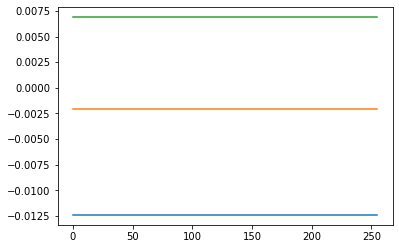

In [28]:
plt.plot(a[0])

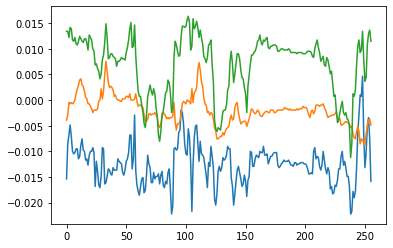

In [29]:
plt.plot(X[0])

In [ ]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

In [ ]:
X[0].shape

In [ ]:
plt.plot(X[0])

In [ ]:
plt.plot(moving_average(X[0][:,0],30))
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w
for i in range(len(X)):
    X[i] = np.apply_along_axis(lambda m: moving_average(m,30), axis=0, arr=X[i])

In [ ]:
plt.plot(X[0][:,:])